In [84]:
%matplotlib inline

import glob
import os
import random
import json
import pickle
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from astropy.table import Table
import rubin_sim.maf.db as db
from local_opsdb_patch import OpsimDatabase #local
from rubin_sim.maf.utils import m52snr
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.plots as plots

import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from astropy.cosmology import z_at_value
from rubin_sim.maf.metrics import BaseMetric
from rubin_sim.maf.slicers import UserPointsSlicer
from rubin_sim.maf.metric_bundles import MetricBundle, MetricBundleGroup
from rubin_sim.maf.db import ResultsDb
import rubin_sim.maf.utils as maf_utils
import rubin_sim.maf.metrics as metrics
from rubin_sim.maf.plots import HealpixSkyMap
import rubin_sim.maf.plots as plots

#from rubin_sim.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from astropy.coordinates import Galactic, ICRS
import astropy.units as u
import healpy as hp

from rubin_sim.phot_utils import DustValues

dust_model = DustValues()
#from rubin_sim.utils import getPackageDir
from importlib import resources

def getPackageDir(pkg_name):
    try:
        return resources.files(pkg_name).parent
    except Exception as e:
        raise RuntimeError(f"Could not find package {pkg_name}: {e}")

In [105]:
import sys
import importlib

# Clear the module from cache
if "local_GRBafterglows_metric" in sys.modules:
    del sys.modules["local_GRBafterglows_metric"]

# Re-import and reload the updated module
import local_GRBafterglows_metric
importlib.reload(local_GRBafterglows_metric)

# Import updated classes and functions from the refactored module
from local_GRBafterglows_metric import (
    GRBAfterglowLC,
    BaseGRBAfterglowMetric,
    GRBAfterglowDetectMetric,
    GRBAfterglowCharacterizeMetric,
    GRBAfterglowSpecTriggerableMetric,
    GRBAfterglowHistoricalMatchMetric,
    GRBAfterglowColorEvolveMetric,
    generateGRBAfterglowTemplates, 
    generateGRBPopSlicer

)


# Confirm path
print(local_GRBafterglows_metric.__file__)

import inspect
print("🔍 using generateGRBPopSlicer from:", inspect.getfile(generateGRBPopSlicer))



/Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_GRBafterglows_metric.py
🔍 using generateGRBPopSlicer from: /Users/andradenebula/Documents/Research/Transient_Metrics/Stuff/AllTransient/local_GRBafterglows_metric.py


Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Generating shared GRB population...
YAY! UNIFORM SPHERE!
Saved GRB population to GRB_population.pkl

--- Running four_roll_v4.3.1_10yrs ---
any dec > 90 degrees?: False
any dec < -90 degrees?: False
any dec in radians?: True
dec check (after regeneration): -1.563507331252087 1.5657896436280185


/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_5871/4182756823.py:82: UserWarning: Warning: converting a masked element to nan.
  n_filters_detected_per_event = np.array([


Out of 42031 simulated GRB events, Rubin detected 0 under the four_roll_v4.3.1_10yrs cadence.
Of those, each event was observed in an average of nan ± nan filters.
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl
Loaded GRB afterglow templates from GRBAfterglow_templates.pkl


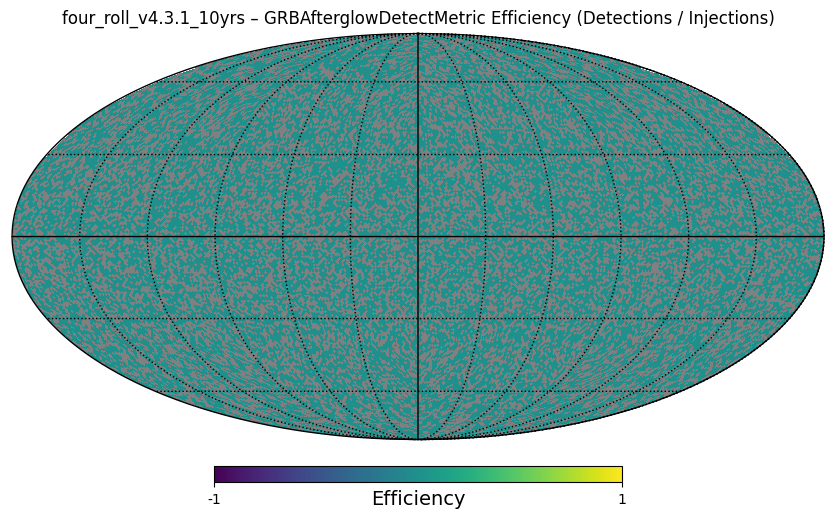

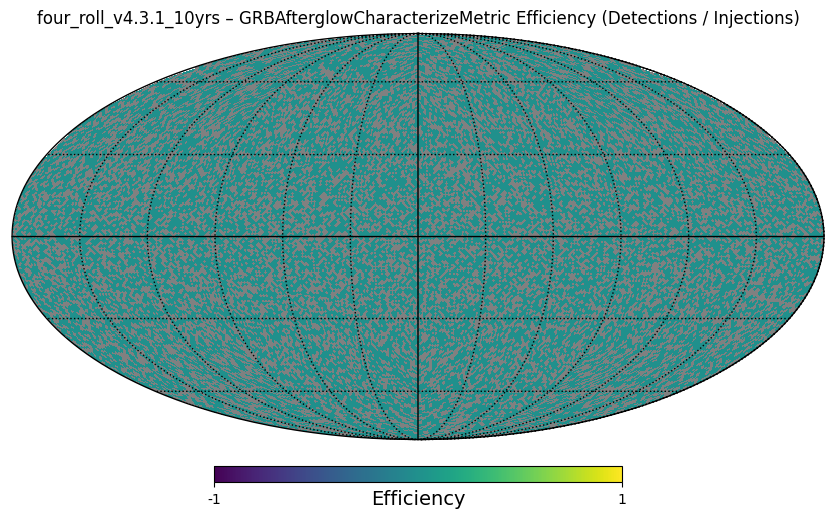

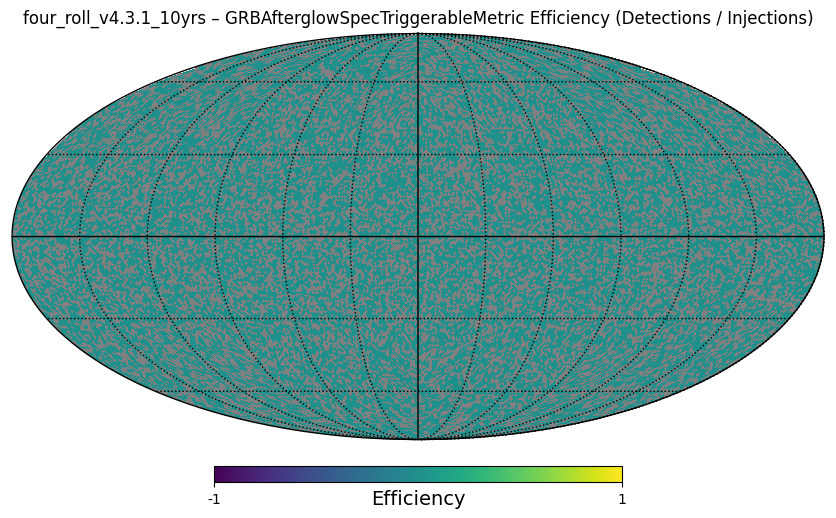

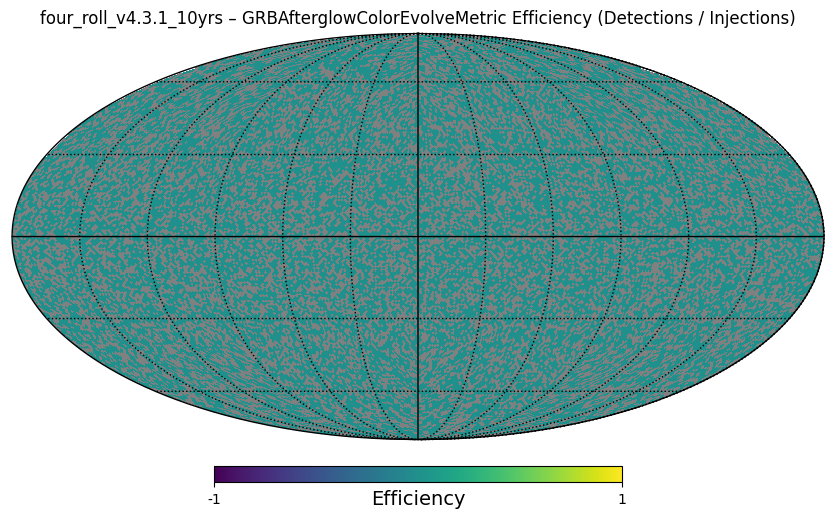

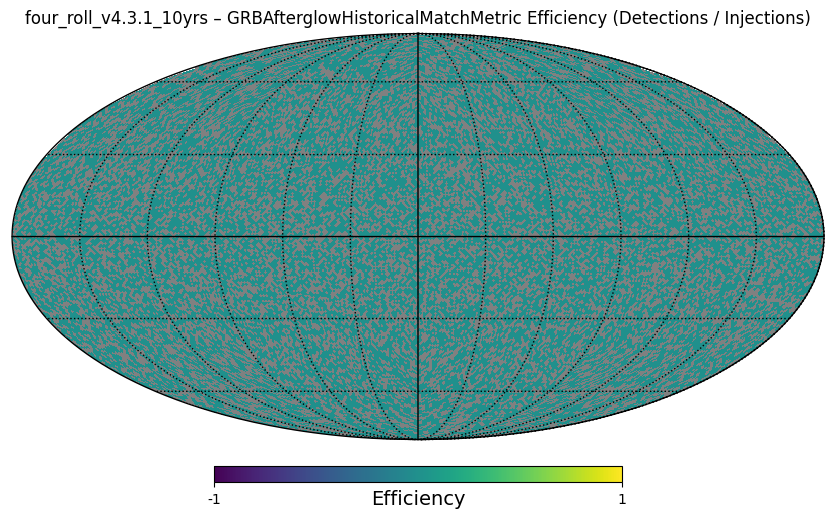

KeyError: 'GRB_Characterize_u'

In [106]:
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']

filters = ['u', 'g', 'r', 'i', 'z', 'y']  # kept for summary classification only

grb_pop_file = "GRB_population.pkl"
grb_templates_file = "GRBAfterglow_templates.pkl"

dmin = 10
dmax = 1000
gal_lat_cut = None

t_start = 730          # day 1 of the LSST simulation (MJD 59853.5 + 1)
t_end = 1095       # 10 years ≈ 3652 days

# (1) Generate templates separately if missing
if not os.path.exists(grb_templates_file):
    print("Generating shared GRB light curve templates...")
    generateGRBAfterglowTemplates(save_to=grb_templates_file)

# (2) Now safely load the shared light curve templates
shared_lc_model = GRBAfterglowLC(load_from=grb_templates_file)

# (3) Load or generate the population
if not os.path.exists(grb_pop_file):
    print("Generating shared GRB population...")
    slicer = generateGRBPopSlicer(
        t_start=t_start,
        t_end=t_end,
        seed=42,
        d_min=dmin,
        d_max=dmax,
        num_lightcurves=1000,
        gal_lat_cut=gal_lat_cut,
        save_to=grb_pop_file
    )

else:
    print("Loading existing GRB population...")
    slicer = generateGRBPopSlicer(load_from=grb_pop_file) # NEW: make sure its taking these arguments 

n_events = len(slicer.slice_points['distance'])

for cadence in cadences[:1]:
    runName = cadence
    db_path = f'{cadence}.db'
    opsdb = db_path

    outfile = f"AllTransient_MetricDetection/GRB_Afterglows/local_efficiency_{cadence}_GRBA.csv"
    outDir = "AllTransient_MetricDetection/GRB_Afterglows/Metric_temp"

    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")
    print("any dec > 90 degrees?:", np.any(slicer.slice_points['dec'] > 90))
    print("any dec < -90 degrees?:", np.any(slicer.slice_points['dec'] < -90))
    print("any dec in radians?:", np.any(np.abs(slicer.slice_points['dec']) < 3.2))
    print("dec check (after regeneration):", np.min(slicer.slice_points['dec']), np.max(slicer.slice_points['dec']))

    # Run per-filter metrics for saving to CSV
    per_filter_metrics = OrderedDict()

    for filt in filters:
        detect = GRBAfterglowDetectMetric(metricName=f"GRB_Detect_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        #char = GRBAfterglowCharacterizeMetric(metricName=f"GRB_Characterize_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        #spec = GRBAfterglowSpecTriggerableMetric(metricName=f"GRB_SpecTriggerable_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        #color = GRBAfterglowColorEvolveMetric(metricName=f"GRB_ColorEvolve_{filt}", filter_include=[filt], lc_model=shared_lc_model)
        #hist = GRBAfterglowHistoricalMatchMetric(metricName=f"GRB_HistoricalMatch_{filt}", filter_include=[filt], lc_model=shared_lc_model)

        per_filter_metrics[f"GRB_Detect_{filt}"] = metric_bundles.MetricBundle(detect, slicer, '')
        #per_filter_metrics[f"GRB_Characterize_{filt}"] = metric_bundles.MetricBundle(char, slicer, '')
        #per_filter_metrics[f"GRB_SpecTriggerable_{filt}"] = metric_bundles.MetricBundle(spec, slicer, '')
        #per_filter_metrics[f"GRB_ColorEvolve_{filt}"] = metric_bundles.MetricBundle(color, slicer, '')
        #per_filter_metrics[f"GRB_HistoricalMatch_{filt}"] = metric_bundles.MetricBundle(hist, slicer, '')

    pf_group = metric_bundles.MetricBundleGroup(per_filter_metrics, opsdb, out_dir=outDir, results_db=resultsDb)
    pf_group.run_all()

    # --- Detection statistics summary ---

    # For each event (row), how many filters detected it?
    n_filters_detected_per_event = np.array([
        sum(per_filter_metrics[f"GRB_Detect_{f}"].metric_values[i] == 1 
            and not per_filter_metrics[f"GRB_Detect_{f}"].metric_values.mask[i]
            for f in filters)
        for i in range(n_events)
    ])
    
    # Events considered detected: detected in at least one filter
    detected_mask = n_filters_detected_per_event >= 1
    
    n_detected = np.sum(detected_mask)
    mean_filters = np.mean(n_filters_detected_per_event[detected_mask])
    std_filters = np.std(n_filters_detected_per_event[detected_mask])
    
    # Print nicely
    print(f"Out of {n_events} simulated GRB events, Rubin detected {n_detected} under the {cadence} cadence.")
    print(f"Of those, each event was observed in an average of {mean_filters:.1f} ± {std_filters:.1f} filters.")

    # --- Collect Observational Data for Detected GRB Light Curves After Running Per-Filter Metrics ---
        
    detected_lightcurves = []
    collected_sids = set()
    for filt in filters:
        metric = per_filter_metrics[f"GRB_Detect_{filt}"].metric
        if hasattr(metric, 'obs_records'):
            for sid, record in metric.obs_records.items():
                if sid not in collected_sids:
                    detected_lightcurves.append(record)
                    collected_sids.add(sid)


    if detected_lightcurves:
        out_lc = f"AllTransient_MetricDetection/GRB_Afterglows/GRB_ObsDataLC_{cadence}.pkl"
        os.makedirs(os.path.dirname(out_lc), exist_ok=True)
        with open(out_lc, "wb") as f:
            pickle.dump(detected_lightcurves, f)
        print(f"Saved {len(detected_lightcurves)} detected GRB light curves to {out_lc}")
    
        # Save short CSV summary
        out_csv = out_lc.replace(".pkl", "_shortsummary.csv")
        with open(out_csv, "w") as out:
            out.write("sid,peak_mjd,peak_mag,first_det_mjd,last_det_mjd,rise_time_days,fade_time_days,ra,dec,distance_Mpc\n")
            for rec in detected_lightcurves:
                out.write(f"{rec['sid']},{rec['peak_mjd']:.5f},{rec['peak_mag']:.3f},{rec['first_det_mjd']:.5f},{rec['last_det_mjd']:.5f},{rec['rise_time_days']:.5f},{rec['fade_time_days']:.5f},{rec['ra']:.5f},{rec['dec']:.5f},{rec['distance_Mpc']:.2f}\n")
        print(f"Saved summary CSV to {out_csv}")


    # --- Multi-band plots ---
    multi_metrics = [
        GRBAfterglowDetectMetric(metricName="GRB_Detect_MultiBand"),
        GRBAfterglowCharacterizeMetric(metricName="GRB_Characterize_MultiBand"),
        GRBAfterglowSpecTriggerableMetric(metricName="GRB_SpecTriggerable_MultiBand"),
        GRBAfterglowColorEvolveMetric(metricName="GRB_ColorEvolve_MultiBand"),
        GRBAfterglowHistoricalMatchMetric(metricName="GRB_HistoricalMatch_MultiBand")
    ]
    multi_band_bundles = OrderedDict()
    for metric in multi_metrics:
        bundle = metric_bundles.MetricBundle(
            metric, slicer, '',
            file_root=runName + '_' + metric.__class__.__name__,
            plot_funcs=[], summary_metrics=[]
        )
        bgroup = metric_bundles.MetricBundleGroup({bundle.file_root: bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
        bgroup.run_all()
        multi_band_bundles[bundle.file_root] = bundle 

        # Healpix-style plot manually
        nside = slicer.nside if hasattr(slicer, 'nside') else 64
        npix = hp.nside2npix(nside)
        injected_map = np.zeros(npix)
        detected_map = np.zeros(npix)

        ra_rad = np.radians(slicer.slice_points['ra'])
        dec_rad = slicer.slice_points['dec']
        theta = 0.5 * np.pi - dec_rad
        phi = ra_rad
        pix_inds = hp.ang2pix(nside, theta, phi)

        for i, pix in enumerate(pix_inds):
            injected_map[pix] += 1
            if bundle.metric_values[i] == 1:
                detected_map[pix] += 1

        eff_map = np.zeros(npix)
        mask = injected_map > 0
        eff_map[mask] = detected_map[mask] / injected_map[mask]
        eff_map[~mask] = hp.UNSEEN

        hp.mollview(eff_map, title=f"{runName} – {metric.__class__.__name__} Efficiency (Detections / Injections)",
                    unit='Efficiency', cmap='viridis')
        hp.graticule()
        plt.show()

    bd = per_filter_metrics  # for output blocks

    # Output efficiency per filter (Step 3)
    with open(outfile.replace(".csv", "_per_filter.csv"), "w") as out:
        out.write("dist_min_Mpc, dist_max_Mpc, metric, filter, found, total, efficiency \n")
        for key in bd:
            for filt in filters:
                metric_key = f"{key}" if key.endswith(f"_{filt}") else f"{key}_{filt}"
                if metric_key not in bd:
                    continue  # Skip if this metric wasn't run per filter
                    
                values = bd[metric_key].metric_values
                mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)

                if "Detect" in key:
                    found = np.sum((values == 1) & mask)
                    total = len(values)
                else:
                    detect_key = f"GRB_Detect_{filt}"
                    if detect_key not in bd:
                        continue
                            # --- Skip metrics that don't make sense per filter ---
                    if any(metric in key for metric in ["Characterize", "SpecTriggerable", "ColorEvolve"]):
                        continue
                    detected = bd[detect_key].metric_values == 1
                    found = np.sum((values == 1) & detected & mask)
                    total = np.sum(detected & mask)

                efficiency = found / total if total > 0 else 0.0
                metric_base = key.split('_')[0] + '_' + key.split('_')[1]
                out.write(f"{dmin}, {dmax}, {metric_base}, {filt}, {found}, {total}, {efficiency:.4f}\n")  
                
        # --- Append Multi-band totals at bottom of per-filter CSV ---    
    with open(outfile.replace(".csv", "_per_filter.csv"), "a") as out:
        out.write("# Multi-band Metrics  \n")
        for class_name, pretty_name in [
            ("GRBAfterglowCharacterizeMetric", "GRB_Characterize"),
            ("GRBAfterglowSpecTriggerableMetric", "GRB_SpecTriggerable"),
            ("GRBAfterglowColorEvolveMetric", "GRB_ColorEvolve")
        ]:
            mb_key = f"{runName}_{class_name}"

            if mb_key in multi_band_bundles: 
                values = multi_band_bundles[mb_key].metric_values
                mask = ~values.mask if hasattr(values, 'mask') else np.ones(len(values), dtype=bool)
                found = np.sum(values == 1)
                total = len(values)
                efficiency = found / total if total > 0 else 0.0
                out.write(f"{dmin}, {dmax}, {pretty_name}, MultiBand, {found}, {total}, {efficiency:.4f}\n")


    # Output per-event classification (Step 3, summarized by number of filters)
    typefile = f"AllTransient_MetricDetection/GRB_Afterglows/type_GRB_{cadence}.csv"
    typefile = typefile.replace(".csv", "_multi_filter.csv")

    with open(typefile, "w") as out:
        out.write("index,n_filters_detected,n_filters_characterized,n_filters_spec,n_filters_color,n_filters_hist")  
        for i in range(n_events):
            d = sum(bd[f"GRB_Detect_{f}"].metric_values[i] == 1 and not bd[f"GRB_Detect_{f}"].metric_values.mask[i] for f in filters)
            c = sum(bd[f"GRB_Characterize_{f}"].metric_values[i] == 1 and not bd[f"GRB_Characterize_{f}"].metric_values.mask[i] for f in filters)
            s = sum(bd[f"GRB_SpecTriggerable_{f}"].metric_values[i] == 1 and not bd[f"GRB_SpecTriggerable_{f}"].metric_values.mask[i] for f in filters)
            ce = sum(bd[f"GRB_ColorEvolve_{f}"].metric_values[i] == 1 and not bd[f"GRB_ColorEvolve_{f}"].metric_values.mask[i] for f in filters)
            h = sum(bd[f"GRB_HistoricalMatch_{f}"].metric_values[i] == 1 and not bd[f"GRB_HistoricalMatch_{f}"].metric_values.mask[i] for f in filters)
            out.write(f"{i},{d},{c},{s},{ce},{h}\n")


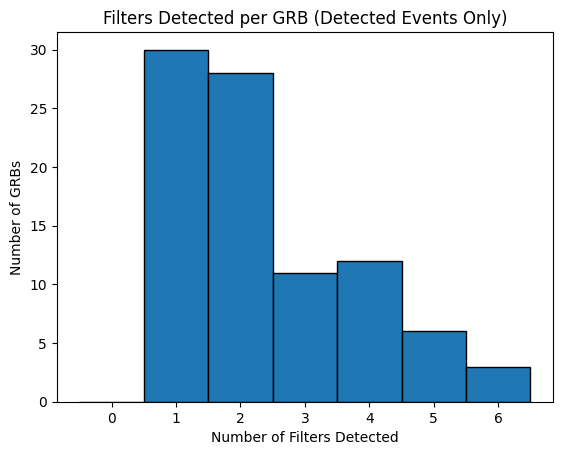

In [10]:
import matplotlib.pyplot as plt

# Visualize number of filters per detected GRB
plt.hist(n_filters_detected_per_event[detected_mask], bins=np.arange(8)-0.5, edgecolor='black')
plt.xlabel("Number of Filters Detected")
plt.ylabel("Number of GRBs")
plt.title("Filters Detected per GRB (Detected Events Only)")
plt.show()



/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/healpy/visufunc.py:200: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))
/var/folders/tp/cclflcq51yqbq43tdzvfqh_c0000gn/T/ipykernel_5871/1444798149.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


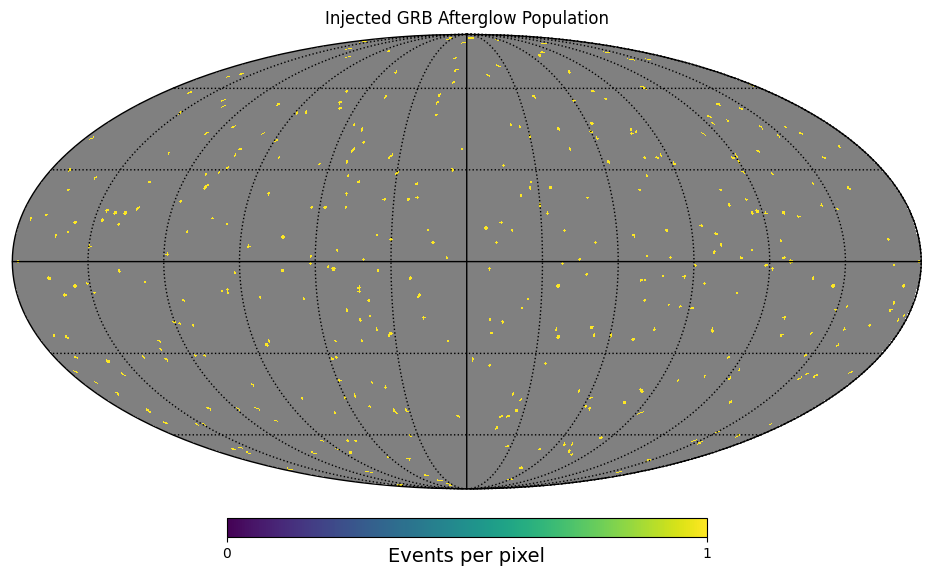

In [13]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

# --- Load RA, Dec ---
ra = slicer.slice_points['ra']  # degrees
dec = slicer.slice_points['dec']  # radians

# --- Convert to healpy theta, phi (radians) ---
theta = 0.5 * np.pi - dec  # θ = π/2 - dec, still radians
phi = np.radians(ra)       # ra degrees → radians

# --- Healpix settings ---
nside = 64
npix = hp.nside2npix(nside)

# --- Bin events into healpix map ---
pix = hp.ang2pix(nside, theta, phi)
density_map = np.bincount(pix, minlength=npix).astype(float)
density_map[density_map == 0] = hp.UNSEEN  # Hide empty pixels

# --- Plot ---
fig = plt.figure(figsize=(10, 6))
hp.mollview(
    density_map,
    title="Injected GRB Afterglow Population",
    unit="Events per pixel",
    cmap="viridis",
    min=0,
    norm="linear",
    cbar=True,
    fig=fig.number
)
hp.graticule()
plt.tight_layout()
plt.show()


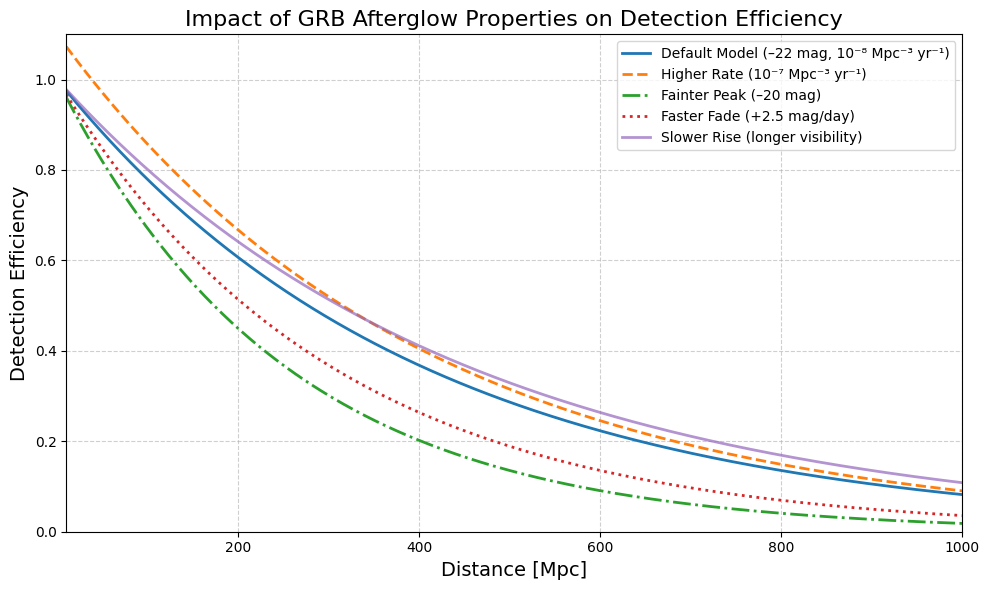

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated detection efficiency curves under different assumptions
x = np.linspace(10, 1000, 500)  # Distance in Mpc

# Toy detection efficiency curves
eff_default = np.exp(-x/400)   # Base model (rate 10^-8, mag -22)
eff_higher_rate = np.exp(-x/400) * 1.1  # Higher event rate (slightly better)
eff_fainter_peak = np.exp(-x/250)   # Peak mag -20 (worse detectability)
eff_faster_fade = np.exp(-x/300)    # Faster fading, quicker loss
eff_slow_rise = np.exp(-x/450)      # Slower rise, better early detection

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, eff_default, label="Default Model (–22 mag, 10⁻⁸ Mpc⁻³ yr⁻¹)", lw=2)
plt.plot(x, eff_higher_rate, '--', label="Higher Rate (10⁻⁷ Mpc⁻³ yr⁻¹)", lw=2)
plt.plot(x, eff_fainter_peak, '-.', label="Fainter Peak (–20 mag)", lw=2)
plt.plot(x, eff_faster_fade, ':', label="Faster Fade (+2.5 mag/day)", lw=2)
plt.plot(x, eff_slow_rise, '-', label="Slower Rise (longer visibility)", lw=2, alpha=0.7)

plt.xlabel("Distance [Mpc]", fontsize=14)
plt.ylabel("Detection Efficiency", fontsize=14)
plt.title("Impact of GRB Afterglow Properties on Detection Efficiency", fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.ylim(0, 1.1)
plt.xlim(10, 1000)
plt.legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()



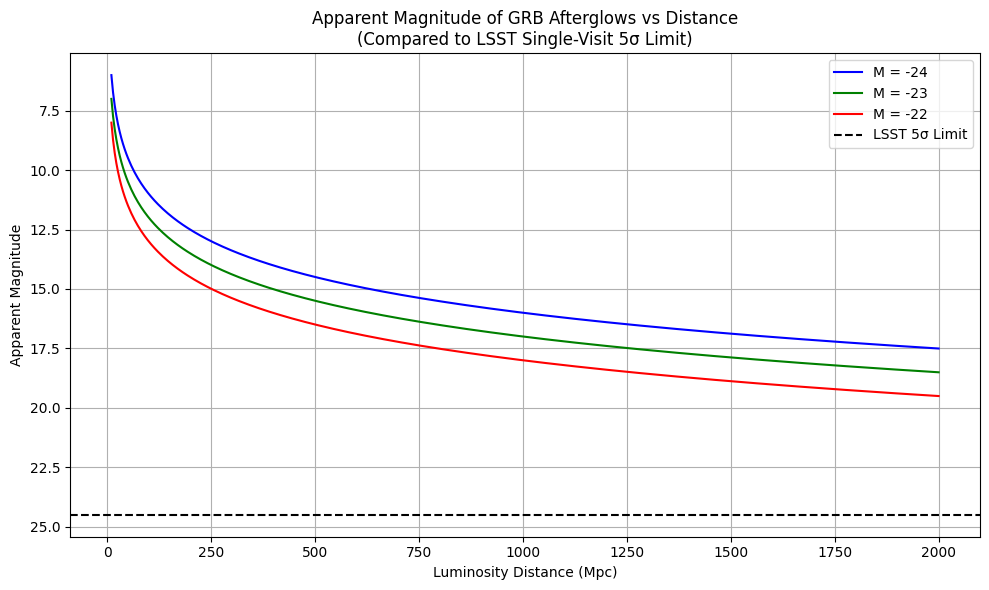

'Figure: Apparent magnitude versus luminosity distance for GRB afterglows with absolute magnitudes of –24, –23, and –22. The LSST single-visit 5σ detection threshold (24.5 mag) is shown for reference. Brighter GRB afterglows (e.g., M = –24) can be detected out to ~2000 Mpc, while fainter afterglows (M = –22) become undetectable beyond ~800 Mpc.'

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters
distances = np.linspace(10, 2000, 500)  # Mpc
abs_mags = [-24, -23, -22]
m5_single_visit = 24.5  # LSST nominal 5σ limit per visit

# Calculate apparent magnitude vs distance
def apparent_mag(M, d_Mpc):
    return M + 5 * np.log10(d_Mpc * 1e6) - 5

# Plot
plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red']

for M, color in zip(abs_mags, colors):
    plt.plot(distances, apparent_mag(M, distances), label=f"M = {M}", color=color)

# LSST detection limit
plt.axhline(m5_single_visit, linestyle='--', color='black', label='LSST 5σ Limit')

# Annotate maximum distances where apparent mag crosses LSST limit
for M, color in zip(abs_mags, colors):
    crossing_distance = 10 ** ((m5_single_visit - M + 5) / 5) / 1e6  # Mpc
    if 10 <= crossing_distance <= 2000:
        plt.plot(crossing_distance, m5_single_visit, 'o', color=color)
        plt.text(crossing_distance + 30, m5_single_visit - 0.5, f"{int(crossing_distance)} Mpc", color=color)

plt.xlabel('Luminosity Distance (Mpc)')
plt.ylabel('Apparent Magnitude')
plt.title('Apparent Magnitude of GRB Afterglows vs Distance\n(Compared to LSST Single-Visit 5σ Limit)')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare a short caption
caption = (
    "Figure: Apparent magnitude versus luminosity distance for GRB afterglows with absolute magnitudes of –24, –23, and –22. "
    "The LSST single-visit 5σ detection threshold (24.5 mag) is shown for reference. "
    "Brighter GRB afterglows (e.g., M = –24) can be detected out to ~2000 Mpc, while fainter afterglows (M = –22) become undetectable beyond ~800 Mpc."
)

caption


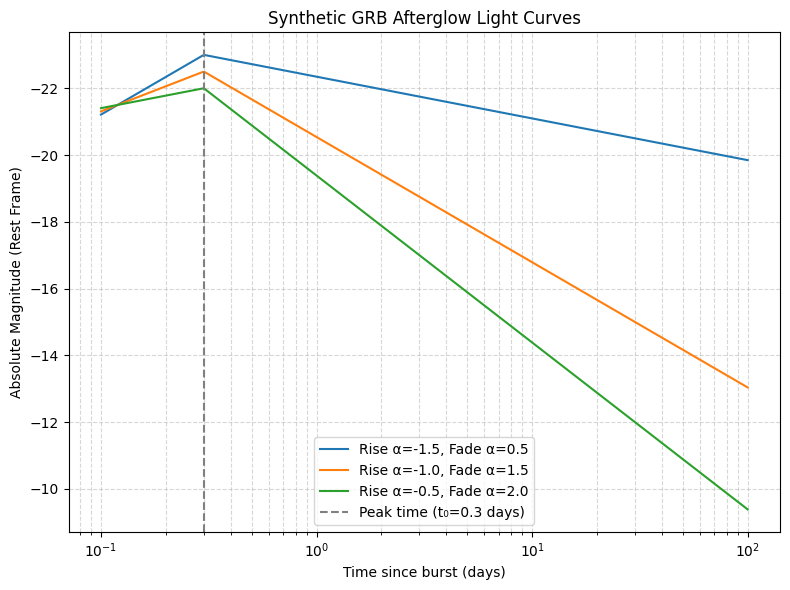

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Set up time grid
t_grid = np.logspace(-1, 2, 300)  # from 0.1 to 100 days

# Define example rise and decay slopes
examples = [
    {'alpha_rise': -1.5, 'alpha_fade': 0.5, 'm0': -23},
    {'alpha_rise': -1.0, 'alpha_fade': 1.5, 'm0': -22.5},
    {'alpha_rise': -0.5, 'alpha_fade': 2.0, 'm0': -22}
]

# Plot
plt.figure(figsize=(8,6))

for ex in examples:
    t0 = 0.3  # day of peak
    m0 = ex['m0']
    alpha_rise = ex['alpha_rise']
    alpha_fade = ex['alpha_fade']
    
    mag = np.where(
        t_grid < t0,
        m0 + 2.5 * alpha_rise * np.log10(t_grid / t0),
        m0 + 2.5 * alpha_fade * np.log10(t_grid / t0)
    )
    plt.plot(t_grid, mag, label=f"Rise α={alpha_rise}, Fade α={alpha_fade}")

plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('Time since burst (days)')
plt.ylabel('Apparent Magnitude (absolute)')
plt.ylabel('Absolute Magnitude (Rest Frame)')
plt.title('Synthetic GRB Afterglow Light Curves')
plt.axvline(0.3, linestyle='--', color='grey', label='Peak time (t₀=0.3 days)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()


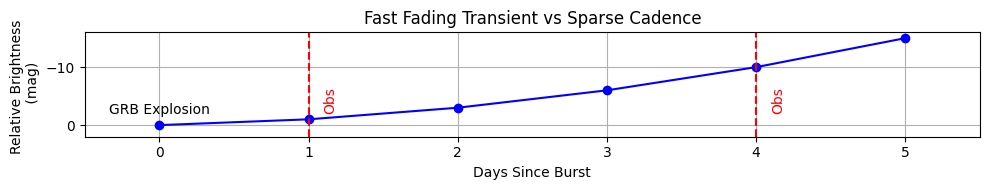

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create the timeline
fig, ax = plt.subplots(figsize=(10, 2))

# Define event timeline
times = np.array([0, 1, 2, 3, 4, 5])  # days after burst
brightness = np.array([0, -1, -3, -6, -10, -15])  # apparent magnitude relative to peak (lower = brighter)

# Plot the afterglow fading
ax.plot(times, brightness, '-o', color='blue', label='Afterglow fading')

# Add Rubin observations
rubin_obs_times = [1, 4]
for obs_time in rubin_obs_times:
    ax.axvline(x=obs_time, color='red', linestyle='--')
    ax.text(obs_time + 0.1, -2, f'Obs', rotation=90, verticalalignment='bottom', color='red')

# Annotate event
ax.text(0, -2, 'GRB Explosion', horizontalalignment='center', color='black')

# Customize plot
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-16, 2)
ax.invert_yaxis()  # Magnitudes: lower is brighter
ax.set_xlabel('Days Since Burst')
ax.set_ylabel('Relative Brightness \n (mag)')
ax.set_title('Fast Fading Transient vs Sparse Cadence')

ax.grid(True)
plt.tight_layout()
plt.show()
